<a href="https://colab.research.google.com/github/Lee-Minsoo-97/License_Plate_Detection_CV_Model/blob/main/Troon_Forecasting_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tuning for: AP
Best Params for AP: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
Tuning for: AR
Best Params for AR: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 1.0}
Tuning for: Interest
Best Params for Interest: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
Tuning for: Others
Best Params for Others: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
Tuning for: Payroll
Best Params for Payroll: {'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 400, 'min_child_weight': 

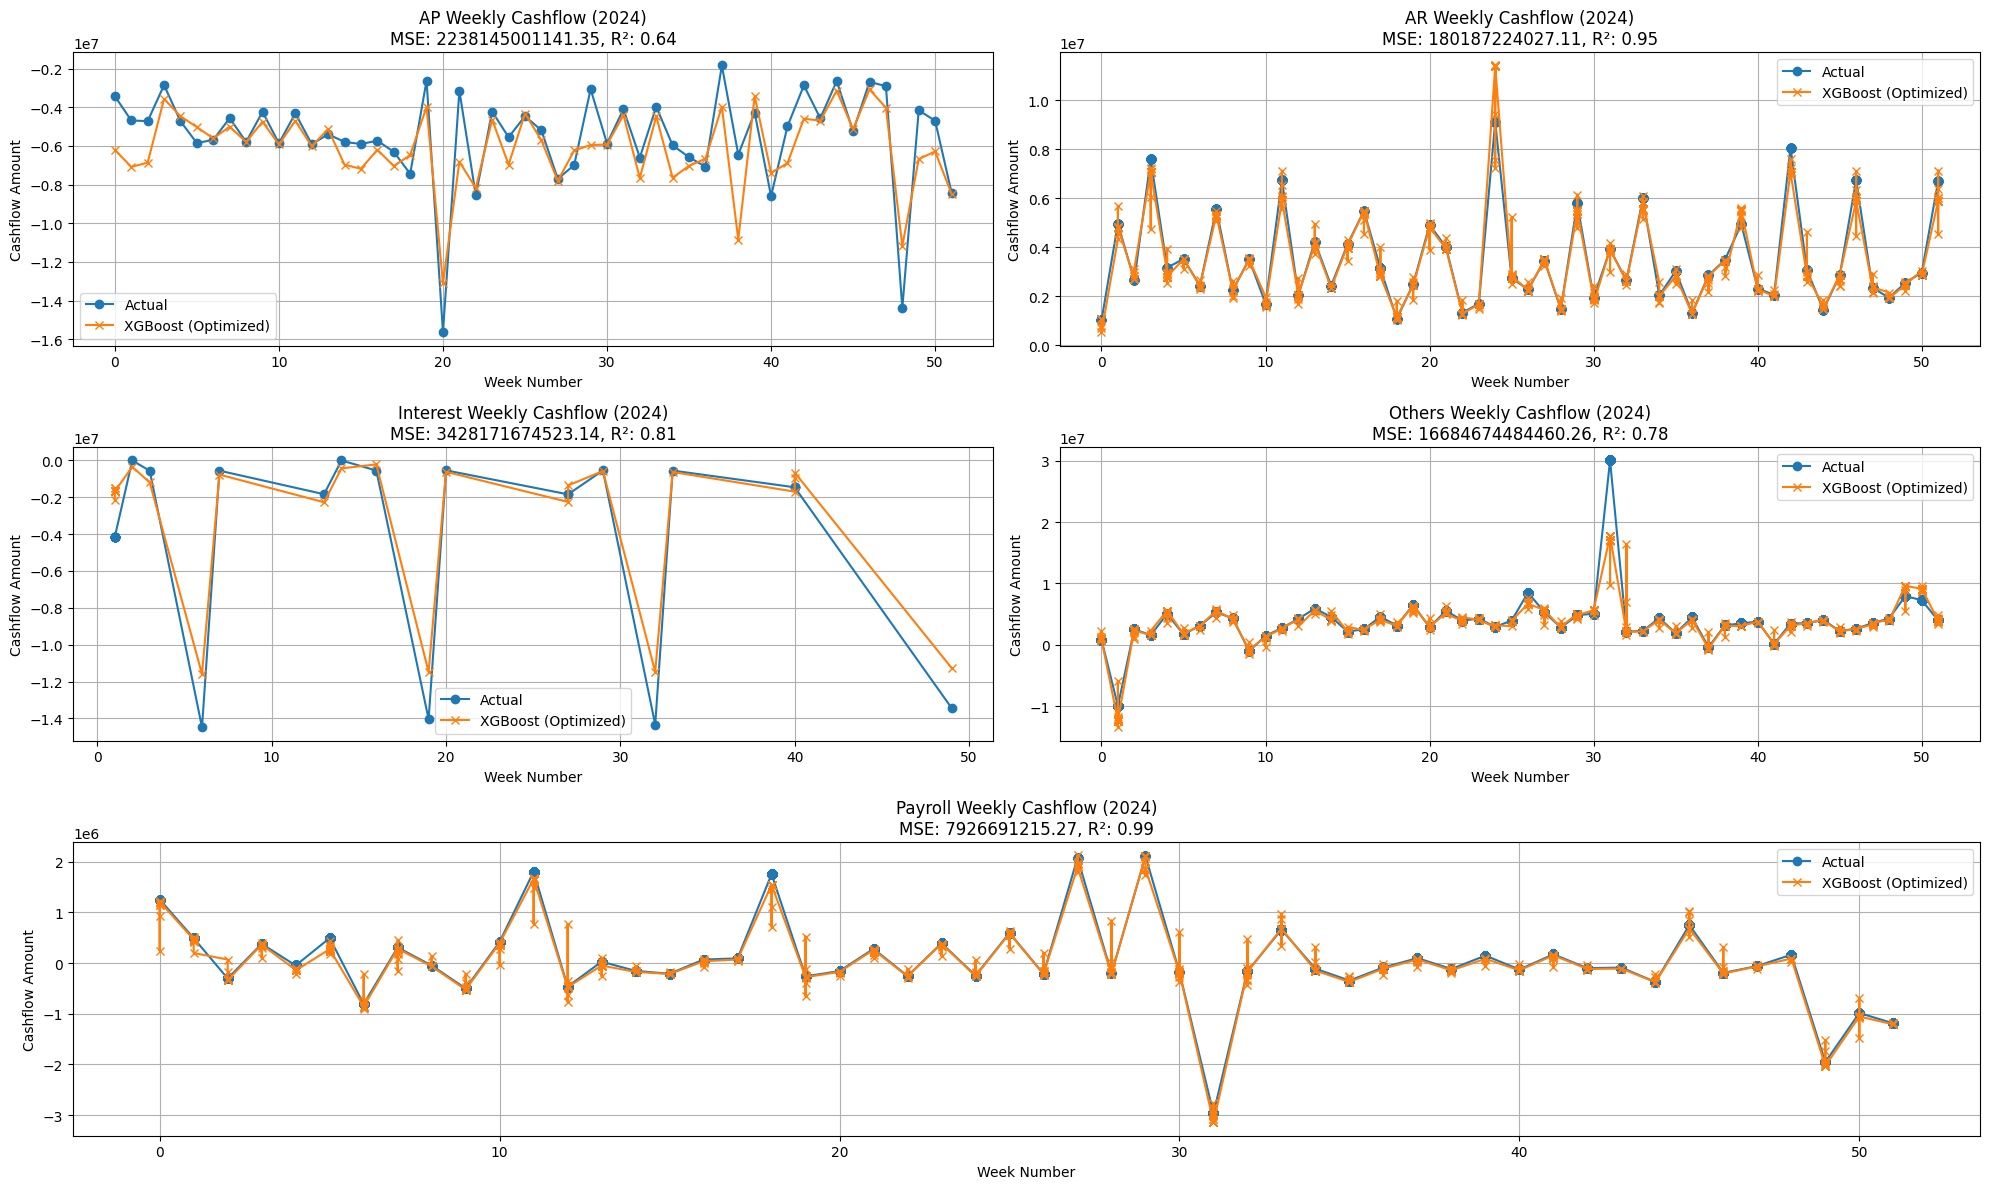

In [ ]:
# 📦 STEP 1: Install & Import Libraries
!pip install -q xgboost lightgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# 📊 STEP 2: Load Excel File
file_path = "/content/drive/MyDrive/Colab Notebooks/Troon/Troon_data with others.xlsx"
xls = pd.ExcelFile(file_path)

# 📄 STEP 3: Load Sheets (5 excel sheets: AP, AR, Payroll, Interests, Others)
ap_df = pd.read_excel(xls, sheet_name='AP')
ar_df = pd.read_excel(xls, sheet_name='AR')
payroll_df = pd.read_excel(xls, sheet_name='Payrolls')
interest_df = pd.read_excel(xls, sheet_name='Interests')
others_df = pd.read_excel(xls, sheet_name='Others')

# 🛠️ STEP 4: Preprocessing Function
def preprocess_cashflow_data(df, category_name):
    df = df.copy()
    df['transdate'] = pd.to_datetime(df['transdate'])
    df['week'] = df['transdate'].dt.isocalendar().week
    df['year'] = df['transdate'].dt.year
    # Keep only relevant columns and rename the amount column
    df = df[['transdate', 'week', 'year', 'amountreportingcurrency']]
    df = df.rename(columns={'amountreportingcurrency': 'amount'})
    df['category'] = category_name
    return df

# 🧹 STEP 5: Clean & Combine Data for Each Category
ap_df_processed       = preprocess_cashflow_data(ap_df, 'AP')
ar_df_processed       = preprocess_cashflow_data(ar_df, 'AR')
payroll_df_processed  = preprocess_cashflow_data(payroll_df, 'Payroll')
interest_df_processed = preprocess_cashflow_data(interest_df, 'Interest')
others_df_processed   = preprocess_cashflow_data(others_df, 'Others')

combined_df = pd.concat([
    ap_df_processed,
    ar_df_processed,
    payroll_df_processed,
    interest_df_processed,
    others_df_processed
])

# 📅 STEP 6: Group Weekly Cashflows
# Aggregate cashflows by category, year, and week
weekly_cashflow_raw = combined_df.groupby(['category', 'year', 'week']).agg({'amount': 'sum'}).reset_index()

# For Method 2 (used for non-AP categories), merge with original transdate to preserve date information
weekly_cashflow_processed = weekly_cashflow_raw.merge(
    combined_df[['transdate', 'week', 'year', 'category']],
    on=['week', 'year', 'category'],
    how='left'
)

# 🔧 STEP 7: Define Two Feature Engineering Functions

# Method 1 Feature Engineering (for AP)
def create_features_method1(df):
    df = df.sort_values(by=['year', 'week']).reset_index(drop=True)
    df['week_index'] = (df['year'] - 2021) * 52 + df['week']
    # Create simple lag features
    df['lag_1'] = df['amount'].shift(1)
    df['lag_2'] = df['amount'].shift(2)
    df['lag_3'] = df['amount'].shift(3)
    # Create simple rolling window features
    df['rolling_3'] = df['amount'].rolling(window=3).mean()
    df['rolling_6'] = df['amount'].rolling(window=6).mean()
    df = df.fillna(0)
    return df

# Method 2 Feature Engineering (for non-AP categories)
def create_features_method2(df):
    df = df.sort_values(by=['year', 'week']).reset_index(drop=True)
    df['week_index'] = (df['year'] - 2021) * 52 + df['week']
    df['month'] = df['transdate'].dt.month
    df['quarter'] = df['transdate'].dt.quarter
    df['is_month_end'] = df['transdate'].dt.is_month_end.astype(int)
    df['is_month_start'] = df['transdate'].dt.is_month_start.astype(int)
    df['lag_1'] = df['amount'].shift(1)
    df['lag_2'] = df['amount'].shift(2)
    df['lag_3'] = df['amount'].shift(3)
    df['rolling_3'] = df['amount'].rolling(window=3).mean()
    df['rolling_6'] = df['amount'].rolling(window=6).mean()
    df['ema_3'] = df['amount'].ewm(span=3, adjust=False).mean()
    df['ema_6'] = df['amount'].ewm(span=6, adjust=False).mean()
    period = 52
    order = 3
    for k in range(1, order + 1):
        df[f'sin_{k}'] = np.sin(2 * np.pi * k * df['week_index'] / period)
        df[f'cos_{k}'] = np.cos(2 * np.pi * k * df['week_index'] / period)
    df = df.fillna(0)
    return df

# Define feature column lists for each method
feature_cols_method1 = ['week_index', 'lag_1', 'lag_2', 'lag_3', 'rolling_3', 'rolling_6']
feature_cols_method2 = [
    'week_index', 'month', 'quarter', 'is_month_end', 'is_month_start',
    'lag_1', 'lag_2', 'lag_3', 'rolling_3', 'rolling_6',
    'ema_3', 'ema_6', 'sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3'
]

# 🎯 STEP 8: Hyperparameter Tuning with RandomizedSearchCV
best_params = {}
param_dist = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5, 2],
    'reg_alpha': [0, 0.1, 0.5, 1]
}

# Loop through each category and apply different strategies for AP vs. others.
for category in weekly_cashflow_raw['category'].unique():
    print(f"Tuning for: {category}")
    if category == 'AP':
        # For AP: Use Method 1 with buffer extension for test set feature engineering
        ap_df_cat = weekly_cashflow_raw[weekly_cashflow_raw['category'] == category].copy()
        ap_df_cat = ap_df_cat.sort_values(by=['year', 'week']).reset_index(drop=True)

        # Split into training (<=2023) and testing (2024)
        train_df = ap_df_cat[ap_df_cat['year'] <= 2023].copy()
        test_df = ap_df_cat[ap_df_cat['year'] == 2024].copy()

        # Extend test set with a buffer (last 6 weeks of 2023) to compute accurate lag features
        buffer_df = ap_df_cat[ap_df_cat['year'] == 2023].tail(6).copy()
        extended_df = pd.concat([buffer_df, test_df], ignore_index=True)

        # Apply Method 1 feature engineering on both training and extended test data
        train_df = create_features_method1(train_df)
        extended_df = create_features_method1(extended_df)
        # Extract test features (only rows from 2024)
        test_features = extended_df[extended_df['year'] == 2024]

        X_train = train_df[feature_cols_method1]
        y_train = train_df['amount']
        X_test = test_features[feature_cols_method1]
        y_test = test_features['amount']

    else:
        # For non-AP categories: Use Method 2 feature engineering
        cat_df = weekly_cashflow_processed[weekly_cashflow_processed['category'] == category].copy()
        cat_df = create_features_method2(cat_df)
        train_df = cat_df[cat_df['year'] <= 2023]
        test_df = cat_df[cat_df['year'] == 2024]

        X_train = train_df[feature_cols_method2]
        y_train = train_df['amount']
        X_test = test_df[feature_cols_method2]
        y_test = test_df['amount']

    # Initialize XGBoost model
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

    # Use RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=50,  # Try 50 combinations
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=0,
        random_state=42
    )
    random_search.fit(X_train, y_train)
    best_params[category] = random_search.best_params_
    print(f"Best Params for {category}: {best_params[category]}")

    # Save the tuned training data for each category for later use in Step 9
    if category == 'AP':
        best_params[category]['X_train'] = X_train
        best_params[category]['y_train'] = y_train
        best_params[category]['X_test'] = X_test
        best_params[category]['y_test'] = y_test
    else:
        best_params[category]['X_train'] = X_train
        best_params[category]['y_train'] = y_train
        best_params[category]['X_test'] = X_test
        best_params[category]['y_test'] = y_test

# 🚀 STEP 9: Train & Predict with Optimized XGBoost
results = {}

for category in weekly_cashflow_raw['category'].unique():
    print(f"Training and predicting for: {category}")
    if category == 'AP':
        X_train = best_params[category]['X_train']
        y_train = best_params[category]['y_train']
        X_test = best_params[category]['X_test']
        y_test = best_params[category]['y_test']
    else:
        X_train = best_params[category]['X_train']
        y_train = best_params[category]['y_train']
        X_test = best_params[category]['X_test']
        y_test = best_params[category]['y_test']

    # Initialize optimized XGBoost with tuned hyperparameters (excluding dataset keys)
    model = XGBRegressor(**{k: v for k, v in best_params[category].items() if k not in ['X_train','y_train','X_test','y_test']},
                         objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[category] = {
        'test_weeks': X_test['week_index'] % 52,  # approximate week number from week_index
        'actual': y_test.values,
        'xgb_pred': y_pred,
        'mse_xgb': mean_squared_error(y_test, y_pred),
        'r2_xgb': r2_score(y_test, y_pred)
    }

# 📈 STEP 10: Plot Results with Sorted X-Axis Values
# Create a figure with a custom GridSpec layout:
# 3 rows and 2 columns, where the first two rows have 2 subplots each and the last row spans both columns.
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Create individual subplots based on the GridSpec:
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, :])  # Last row spanning both columns

# Combine all axes into a list for easy iteration.
axes = [ax1, ax2, ax3, ax4, ax5]

# Plot results for each category using the corresponding axis.
for idx, (category, data_dict) in enumerate(results.items()):
    ax = axes[idx]
    # Extract the week numbers, actual values, and predictions
    weeks = data_dict['test_weeks'].values
    actual = data_dict['actual']
    xgb_pred = data_dict['xgb_pred']

    # Sort the data by week (ascending order)
    sort_idx = np.argsort(weeks)
    weeks_sorted = weeks[sort_idx]
    actual_sorted = actual[sort_idx]
    xgb_pred_sorted = xgb_pred[sort_idx]

    # Plot actual values and predictions with different markers.
    ax.plot(weeks_sorted, actual_sorted, label='Actual', marker='o')
    ax.plot(weeks_sorted, xgb_pred_sorted, label='XGBoost (Optimized)', marker='x')

    # Set the title with category name and performance metrics.
    ax.set_title(
        f'{category} Weekly Cashflow (2024)\n'
        f'MSE: {data_dict["mse_xgb"]:.2f}, R²: {data_dict["r2_xgb"]:.2f}'
    )

    # Label the x and y axes.
    ax.set_xlabel("Week Number")
    ax.set_ylabel("Cashflow Amount")

    # Add a legend and grid for clarity.
    ax.legend()
    ax.grid(True)

# Adjust layout to prevent overlapping elements.
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Checking the Feature Creation Windows for AP ---

try:
    # Ensure weekly_cashflow_raw exists
    ap_group = weekly_cashflow_raw[weekly_cashflow_raw['category'] == 'AP'].copy()
except NameError:
    print("Error: 'weekly_cashflow_raw' is not defined. Please run the cells containing Steps 1–6 first.")
    raise

# Apply the AP-specific feature engineering function to check features
ap_features = create_features_method1(ap_group)

# Display the first 10 rows with relevant columns
print("First 10 rows of the AP feature-engineered data:")
print(ap_features[['year', 'week', 'week_index', 'amount', 'lag_1', 'rolling_3']].head(10))

# Verify that 'lag_1' equals the previous row's 'amount'
print("\nVerifying lag_1 feature (each row's lag_1 should equal the previous row's amount):")
for i in range(1, 10):
    expected = ap_features.loc[i-1, 'amount']
    actual = ap_features.loc[i, 'lag_1']
    print(f"Row {i}: lag_1 = {actual}, Expected (row {i-1} amount) = {expected}")

# Verify that 'rolling_3' is computed as the average of the previous 3 rows' amounts (for rows with index >= 3)
print("\nVerifying rolling_3 feature (mean of the 3 previous rows' amounts):")
for i in range(3, 10):
    expected = ap_features.loc[i-3:i-1, 'amount'].mean()
    actual = ap_features.loc[i, 'rolling_3']
    print(f"Row {i}: rolling_3 = {actual:.2f}, Expected = {expected:.2f}")

Error: 'weekly_cashflow_raw' is not defined. Please run the cells containing Steps 1–6 first.


NameError: name 'weekly_cashflow_raw' is not defined